# EN3150 Assignment 03

Team Name : Nova
</br>
Team members : Induwara, Pavan, Sandali, Devindie

### Setup Environment

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

if device.type == 'cuda':
    print('CUDA device name:', torch.cuda.get_device_name(0))

Device: cuda
CUDA device name: Tesla T4


In [2]:
import os
import json
from PIL import Image
import random
import shutil
from math import floor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary

import time
from torchvision import datasets, transforms, models
import copy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score
from tqdm import tqdm


### Download Dataset

In [3]:
!git clone https://github.com/sam-single/realwaste.git

Cloning into 'realwaste'...
remote: Enumerating objects: 4782, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4782 (delta 4), reused 8 (delta 1), pack-reused 4764 (from 1)
Receiving objects: 100% (4782/4782), 655.92 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4754/4754), done.


In [4]:
import os
current_dir = os.getcwd()

dataset_path = f'{current_dir}/realwaste/RealWaste'

### Load and split the dataset

Here we used the [RealWaste](https://archive.ics.uci.edu/dataset/908/realwaste) from UCI Machine Learning Repository.

In [5]:
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [6]:
# Remove existing split directories if they exist
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Create output directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Set random seed for reproducibility
random.seed(42)

# Split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create class subfolders inside each split
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image files
    images = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
    random.shuffle(images)

    total = len(images)
    train_end = floor(total * train_ratio)
    val_end = floor(total * (train_ratio + val_ratio))

    # Split lists
    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    # Copy files to respective folders
    for file_list, dest_dir in [
        (train_files, os.path.join(train_dir, class_name)),
        (val_files, os.path.join(val_dir, class_name)),
        (test_files, os.path.join(test_dir, class_name))
    ]:
        for filename in file_list:
            src = os.path.join(class_path, filename)
            dst = os.path.join(dest_dir, filename)
            shutil.copy2(src, dst)

    print(f"{class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\nDataset successfully split into train/val/test folders!")

Cardboard: 322 train, 69 val, 70 test
Miscellaneous Trash: 346 train, 74 val, 75 test
Vegetation: 305 train, 65 val, 66 test
Textile Trash: 222 train, 48 val, 48 test
Food Organics: 287 train, 62 val, 62 test
Plastic: 644 train, 138 val, 139 test
Glass: 294 train, 63 val, 63 test
Paper: 350 train, 75 val, 75 test
Metal: 553 train, 118 val, 119 test

Dataset successfully split into train/val/test folders!


### Data preprocessing

After splitting the dataset into train, validation, and test sets, the number of images per class is imbalanced. To address this, we preprocess the training data by applying data augmentation techniques to increase the number of samples in underrepresented classes. This helps create a more balanced training set, improving the model's ability to learn and generalize across all classes.

In [7]:
# The number of images you want per class after augmentation
target_per_class = 1000

In [8]:
# augmentation pipeline for saving (applied to PIL images)
save_aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # crop & resize
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((128,128)),
])

def make_augmented_images_for_class(class_train_dir, target_count, transforms, seed=42):
    """
    class_train_dir: e.g. "dataset_split/train/Cardboard"
    target_count: desired total images in this folder (including originals)
    transforms: torchvision transforms (expects PIL input)
    """
    random.seed(seed)
    existing_files = [f for f in os.listdir(class_train_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    current = len(existing_files)
    if current >= target_count:
        print(f"{os.path.basename(class_train_dir)} already has {current} >= {target_count}. Skipping.")
        return

    # make an 'aug' subfolder or just save into same folder with suffix
    idx = 0
    pbar = tqdm(total=(target_count - current), desc=f"Augment {os.path.basename(class_train_dir)}")
    # cycle over existing images and create variations
    existing_files_without_aug = [f for f in os.listdir(class_train_dir) if f.lower().endswith(('.jpg','.jpeg','.png')) and f.lower().startswith('aug_')==False]

    while current < target_count:
        src_fname = random.choice(existing_files_without_aug)
        src_path = os.path.join(class_train_dir, src_fname)
        try:
            img = Image.open(src_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {src_path}: {e}")
            continue

        aug_img = transforms(img)  # returns PIL or tensor depending on transforms; ensure PIL -> PIL
        # If transforms return a tensor, convert back to PIL before saving:
        if isinstance(aug_img, torch.Tensor):
            aug_img = transforms.ToPILImage()(aug_img)

        # create unique filename
        new_fname = f"aug_{idx:05d}__{src_fname}"
        new_path = os.path.join(class_train_dir, new_fname)
        if os.path.exists(new_path):
            continue  # avoid overwriting
        aug_img.save(new_path, quality=95)
        idx += 1
        current += 1
        pbar.update(1)

    pbar.close()
    print(f"Finished {os.path.basename(class_train_dir)}: now {current} images.")


train_root = train_dir

for class_name in os.listdir(train_root):
    class_dir = os.path.join(train_root, class_name)
    if not os.path.isdir(class_dir):
        continue
    make_augmented_images_for_class(class_dir, target_per_class, save_aug_transforms)


Augment Cardboard: 100%|██████████| 678/678 [00:03<00:00, 178.03it/s]


Finished Cardboard: now 1000 images.


Augment Miscellaneous Trash: 100%|██████████| 654/654 [00:04<00:00, 141.50it/s]


Finished Miscellaneous Trash: now 1000 images.


Augment Vegetation: 100%|██████████| 695/695 [00:04<00:00, 158.97it/s]


Finished Vegetation: now 1000 images.


Augment Textile Trash: 100%|██████████| 778/778 [00:04<00:00, 157.38it/s]


Finished Textile Trash: now 1000 images.


Augment Food Organics: 100%|██████████| 713/713 [00:04<00:00, 155.58it/s]


Finished Food Organics: now 1000 images.


Augment Plastic: 100%|██████████| 356/356 [00:02<00:00, 176.68it/s]


Finished Plastic: now 1000 images.


Augment Glass: 100%|██████████| 706/706 [00:03<00:00, 184.62it/s]


Finished Glass: now 1000 images.


Augment Paper: 100%|██████████| 650/650 [00:04<00:00, 144.69it/s]


Finished Paper: now 1000 images.


Augment Metal: 100%|██████████| 447/447 [00:02<00:00, 180.89it/s]

Finished Metal: now 1000 images.


Cache the dataset for fast retrieve

In [9]:
# configs
batch_size = 32
img_size = 128

# normalized transforms (only used if not using cache)
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

cpu_count = os.cpu_count() or 4
num_workers = cpu_count // 2
print("num_workers:", num_workers)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True,
                              prefetch_factor=2, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True, persistent_workers=True)

classes = train_dataset.classes
num_classes = len(classes)

# print quick dataset stats
print(f"num_classes: {num_classes}, batch_size: {batch_size}")
n_train = len(train_dataset)
print("Training samples", n_train)

# Quick throughput check (small sample) to confirm speed-up
def bench_loader(loader, batches=10):
    t0 = time.time()
    it = iter(loader)
    for i in range(batches):
        try:
            _ = next(it)
        except StopIteration:
            break
    t1 = time.time()
    avg = (t1 - t0) / max(1, i+1)
    print(f"Bench: {i+1} batches in {t1-t0:.2f}s (avg {avg:.3f}s/batch)")

print("Benchmarking train_loader (10 batches)...")
bench_loader(train_loader, batches=10)


num_workers: 1
num_classes: 9, batch_size: 32
Training samples 9000
Benchmarking train_loader (10 batches)...
Bench: 10 batches in 0.97s (avg 0.097s/batch)


### Data visualization

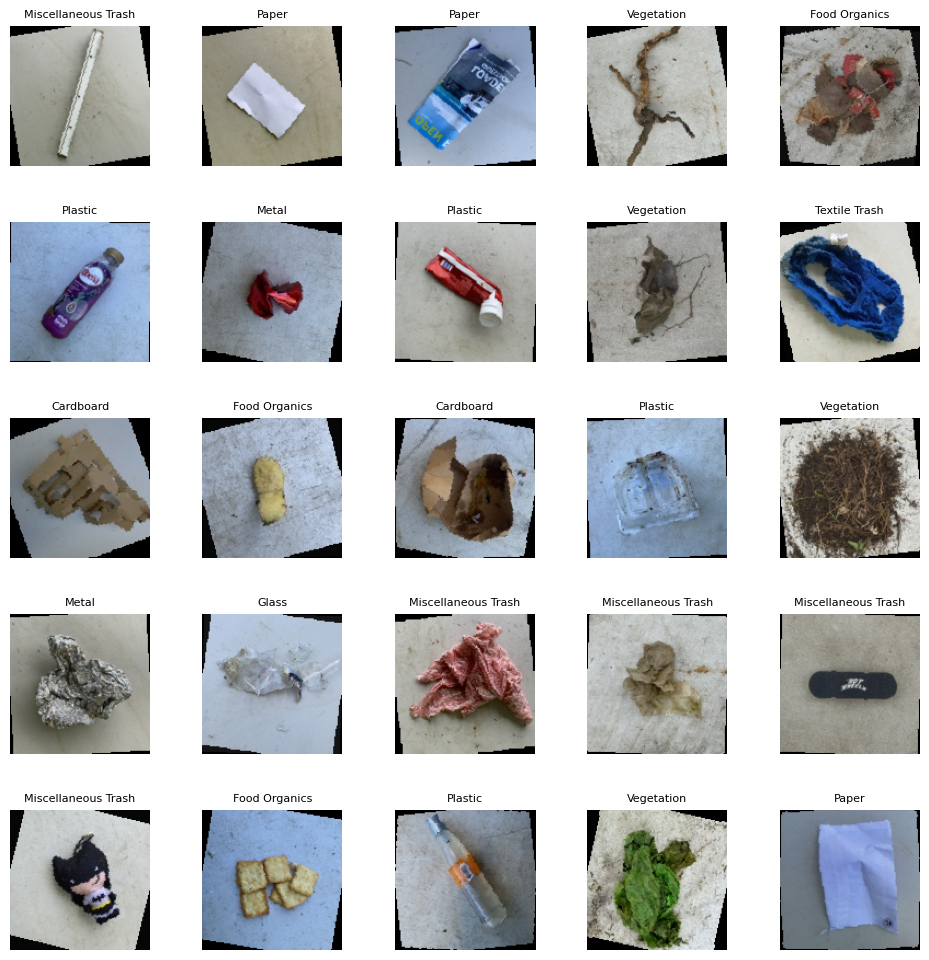

In [11]:
# Get one batch from train_loader
X_batch, y_batch = next(iter(train_loader))

W_grid, L_grid = 5,5
fig, axes = plt.subplots(L_grid, W_grid, figsize=(12,12))
axes = axes.ravel()

for i in range(W_grid*L_grid):
    img = X_batch[i].permute(1,2,0).numpy()   # C,H,W → H,W,C
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])  # unnormalize
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(classes[y_batch[i]], fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()


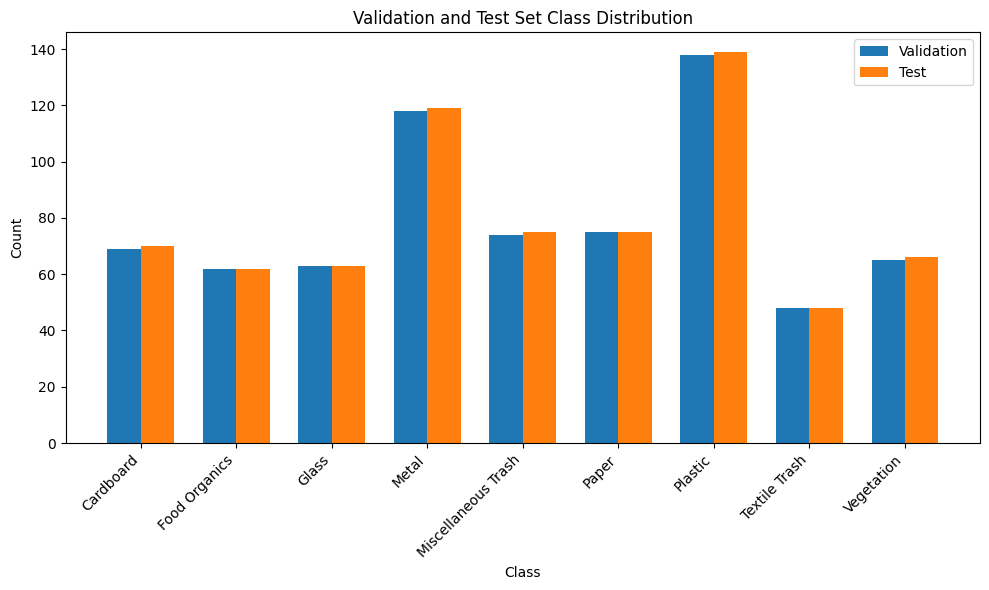

In [12]:
import pandas as pd
import os
import numpy as np

val_counts   = {cls: len(os.listdir(os.path.join(val_dir, cls))) for cls in classes}
test_counts  = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

df_val   = pd.DataFrame(list(val_counts.items()), columns=['Class','Count'])
df_test  = pd.DataFrame(list(test_counts.items()), columns=['Class','Count'])

# Combine dataframes for plotting
df_combined = pd.merge(df_val, df_test, on='Class', suffixes=('_Val', '_Test'))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(df_combined['Class']))

bar1 = ax.bar(index, df_combined['Count_Val'], bar_width, label='Validation')
bar2 = ax.bar(index + bar_width, df_combined['Count_Test'], bar_width, label='Test')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Validation and Test Set Class Distribution')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_combined['Class'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

### Build the Model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=9, dropout_conv=0.1, dropout_fc=0.2):
        super().__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # /2
            nn.Dropout2d(dropout_conv)
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # /4
            nn.Dropout2d(dropout_conv)
        )

        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # /8
            nn.Dropout2d(dropout_conv)
        )

        # Optional Block 4 (light)
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # don't pool here (keeps spatial info, GAP will handle pooling)
            nn.Dropout2d(dropout_conv)
        )

        # Global Average Pooling + small FC
        # GAP will convert (B, C, H, W) -> (B, C, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))   # global average
        self.fc1 = nn.Linear(256, 128)
        self.dropout_fc = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(128, num_classes)

        # initialize weights
        self._init_weights()

    def _init_weights(self):
        # Kaiming init for convs and linear
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.block1(x)   # -> B x 64 x H/2 x W/2
        x = self.block2(x)   # -> B x 128 x H/4 x W/4
        x = self.block3(x)   # -> B x 256 x H/8 x W/8
        x = self.block4(x)   # -> B x 256 x H/8 x W/8

        x = self.gap(x)      # -> B x 256 x 1 x 1
        x = torch.flatten(x, 1)  # -> B x 256

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [ ]:
model = CNNModel(num_classes=len(classes)).to(device)

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
         Dropout2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,728
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,456
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

### Training the Model

In [ ]:
# ---------- History dict ----------
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [],  'val_acc': [],
    'train_prec': [], 'val_prec': [],
    'train_rec': [],  'val_rec': []
}

# ---------- helper functions ----------
def save_history(history, path):
    """Save history dict to JSON (converts numpy types to floats)."""
    serial = {}
    for k, v in history.items():
        # ensure it's a list of plain Python floats/ints
        serial[k] = [float(x) for x in v]
    with open(path, 'w') as f:
        json.dump(serial, f, indent=2)

def load_history(path, default=None):
    """Load history JSON if exists, else return default history."""
    if default is None:
        default = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [],  'val_acc': [],
            'train_prec': [], 'val_prec': [],
            'train_rec': [],  'val_rec': []
        }
    if os.path.exists(path):
        with open(path, 'r') as f:
            loaded = json.load(f)
        # ensure all keys exist and are lists
        for k in default:
            if k not in loaded:
                loaded[k] = []
        return loaded
    return default

def align_history_and_ckpt(history, ckpt_epoch):
    """
    Align history length with checkpoint epoch if possible.
    ckpt_epoch = last saved epoch in checkpoint (int) or None
    Returns (history, start_epoch)
    """
    # find min length among history lists
    lengths = [len(v) for v in history.values()]
    min_len = min(lengths) if lengths else 0
    # truncate all lists to same min_len (defensive)
    for k in list(history.keys()):
        history[k] = history[k][:min_len]

    # determine start epoch
    if ckpt_epoch is not None:
        # if history length is <= ckpt_epoch, we resume from ckpt_epoch+1
        start_epoch = ckpt_epoch + 1
        # if history already longer than ckpt_epoch+1, prefer history length
        if min_len > start_epoch:
            start_epoch = min_len
    else:
        start_epoch = min_len
    return history, start_epoch

**Hyper parameters**

In [ ]:
checkpoint_path = 'checkpoint.pth'   # will save model+opt states here
history_path = 'history.json'

num_epochs = 50                      # total epochs to run (will resume from checkpoint epoch)
patience = 7                         # early stopping patience


# ---------- Model, criterion, optimizer ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# (optional) scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [ ]:
history = load_history(history_path)

# ---------- Helper: load checkpoint if exists ----------
start_epoch = 0
best_val_loss = np.inf
epochs_no_improve = 0

if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    # two formats supported:
    # full checkpoint (dict with keys) or legacy model.state_dict()
    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        model.load_state_dict(ckpt['model_state_dict'])
        if 'optimizer_state_dict' in ckpt:
            try:
                optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                optimizer_state_loaded = True
            except Exception as e:
                print("Warning: couldn't load optimizer state:", e)
        ckpt_epoch = ckpt.get('epoch', None)
        best_val_loss = ckpt.get('best_val_loss', np.inf)
        print(f"Loaded checkpoint (epoch {ckpt_epoch}). Best val loss: {best_val_loss:.4f}")
    else:
        # assume this is a state_dict-only file
        model.load_state_dict(ckpt)
        ckpt_epoch = None
        print("Loaded model.state_dict() from checkpoint (no epoch stored).")
else:
    ckpt_epoch = None
    print("No checkpoint found; starting fresh.")

# align history and compute start_epoch
history, start_epoch = align_history_and_ckpt(history, ckpt_epoch)
print(f"Resuming from epoch: {start_epoch}. History length: {len(history['train_loss'])}")


# ---------- Training Loop ----------
for epoch in range(start_epoch, num_epochs):
    # ----- Training -----
    model.train()
    running_loss = 0.0
    train_preds = []
    train_targets = []

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

        # optional micro-batch display
        train_bar.set_postfix({
            'Batch Loss': f"{running_loss / (len(train_preds) or 1):.4f}",
            'Batch Acc': f"{np.mean(np.array(train_preds) == np.array(train_targets)):.4f}"
        })

    train_loss = running_loss / len(train_targets)
    train_acc = np.mean(np.array(train_preds) == np.array(train_targets))
    # compute precision & recall (macro-average). zero_division=0 avoids warnings if a class not present
    train_prec = precision_score(train_targets, train_preds, average='macro', zero_division=0)
    train_rec = recall_score(train_targets, train_preds, average='macro', zero_division=0)

    # ----- Validation -----
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.detach().cpu().numpy())
            val_targets.extend(labels.detach().cpu().numpy())

            val_bar.set_postfix({
                'Val Loss': f"{val_running_loss / (len(val_targets) or 1):.4f}",
                'Val Acc': f"{np.mean(np.array(val_preds) == np.array(val_targets)):.4f}"
            })

    val_loss = val_running_loss / len(val_targets)
    val_acc = np.mean(np.array(val_preds) == np.array(val_targets))
    val_prec = precision_score(val_targets, val_preds, average='macro', zero_division=0)
    val_rec = recall_score(val_targets, val_preds, average='macro', zero_division=0)

    # store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_prec'].append(train_prec)
    history['val_prec'].append(val_prec)
    history['train_rec'].append(train_rec)
    history['val_rec'].append(val_rec)

    # Save history every epoch (or only on improvement if you prefer)
    save_history(history, history_path)

    # print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Prec: {train_prec:.4f}, Train Rec: {train_rec:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Prec: {val_prec:.4f}, Val Rec: {val_rec:.4f}")

    # ----- Scheduler step if used -----
    scheduler.step(val_loss)  # if using ReduceLROnPlateau, call with val_loss

    # ----- Checkpointing & Early stopping -----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # save full checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)

        # optionally also save history at the same time
        save_history(history, history_path)

        print(f"  Saved improved checkpoint to {checkpoint_path}")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epochs (patience={patience})")

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Loading best model and exiting training loop.")
        ckpt = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        break


Loaded checkpoint (epoch 30). Best val loss: 0.7369
Resuming from epoch: 31. History length: 31


Epoch [32/50] Train Loss: 0.8387, Train Acc: 0.7008, Train Prec: 0.6972, Train Rec: 0.7008 | Val Loss: 0.8130, Val Acc: 0.7205, Val Prec: 0.7281, Val Rec: 0.7290
  No improvement for 1 epochs (patience=7)


Epoch [33/50] Train Loss: 0.8393, Train Acc: 0.7010, Train Prec: 0.6963, Train Rec: 0.7010 | Val Loss: 0.8726, Val Acc: 0.6938, Val Prec: 0.7051, Val Rec: 0.7045
  No improvement for 2 epochs (patience=7)


Epoch [34/50] Train Loss: 0.7630, Train Acc: 0.7249, Train Prec: 0.7208, Train Rec: 0.7249 | Val Loss: 0.6840, Val Acc: 0.7500, Val Prec: 0.7434, Val Rec: 0.7677
  Saved improved checkpoint to checkpoint.pth


Epoch [35/50] Train Loss: 0.7811, Train Acc: 0.7153, Train Prec: 0.7124, Train Rec: 0.7153 | Val Loss: 0.7899, Val Acc: 0.7093, Val Prec: 0.7176, Val Rec: 0.7207
  No improvement for 1 epochs (patience=7)


Epoch [36/50] Train Loss: 0.7541, Train Acc: 0.7288, Train Prec: 0.7256, Train Rec: 0.7288 | Val Loss: 0.7789, Val Acc: 0.7289, Val Prec: 0.7371, Val Rec: 0.7399
  No improvement for 2 epochs (patience=7)


Epoch [37/50] Train Loss: 0.7476, Train Acc: 0.7310, Train Prec: 0.7276, Train Rec: 0.7310 | Val Loss: 0.6743, Val Acc: 0.7584, Val Prec: 0.7557, Val Rec: 0.7659
  Saved improved checkpoint to checkpoint.pth


Epoch [38/50] Train Loss: 0.7029, Train Acc: 0.7490, Train Prec: 0.7466, Train Rec: 0.7490 | Val Loss: 0.6958, Val Acc: 0.7458, Val Prec: 0.7527, Val Rec: 0.7525
  No improvement for 1 epochs (patience=7)


Epoch [39/50] Train Loss: 0.7167, Train Acc: 0.7409, Train Prec: 0.7375, Train Rec: 0.7409 | Val Loss: 0.6337, Val Acc: 0.7739, Val Prec: 0.7776, Val Rec: 0.7913
  Saved improved checkpoint to checkpoint.pth


Epoch [40/50] Train Loss: 0.7004, Train Acc: 0.7519, Train Prec: 0.7491, Train Rec: 0.7519 | Val Loss: 0.6684, Val Acc: 0.7458, Val Prec: 0.7523, Val Rec: 0.7568
  No improvement for 1 epochs (patience=7)


Epoch [41/50] Train Loss: 0.6720, Train Acc: 0.7584, Train Prec: 0.7565, Train Rec: 0.7584 | Val Loss: 0.6947, Val Acc: 0.7444, Val Prec: 0.7556, Val Rec: 0.7586
  No improvement for 2 epochs (patience=7)


Epoch [42/50] Train Loss: 0.6516, Train Acc: 0.7656, Train Prec: 0.7628, Train Rec: 0.7656 | Val Loss: 0.6840, Val Acc: 0.7486, Val Prec: 0.7607, Val Rec: 0.7650
  No improvement for 3 epochs (patience=7)


Epoch [43/50] Train Loss: 0.6503, Train Acc: 0.7746, Train Prec: 0.7732, Train Rec: 0.7746 | Val Loss: 0.6629, Val Acc: 0.7402, Val Prec: 0.7564, Val Rec: 0.7316
  No improvement for 4 epochs (patience=7)


Epoch [44/50] Train Loss: 0.5599, Train Acc: 0.8051, Train Prec: 0.8035, Train Rec: 0.8051 | Val Loss: 0.5918, Val Acc: 0.7865, Val Prec: 0.7969, Val Rec: 0.7873
  Saved improved checkpoint to checkpoint.pth


Epoch [45/50] Train Loss: 0.5392, Train Acc: 0.8067, Train Prec: 0.8046, Train Rec: 0.8067 | Val Loss: 0.5882, Val Acc: 0.7795, Val Prec: 0.7912, Val Rec: 0.7891
  Saved improved checkpoint to checkpoint.pth


Epoch [46/50] Train Loss: 0.5434, Train Acc: 0.8071, Train Prec: 0.8053, Train Rec: 0.8071 | Val Loss: 0.5851, Val Acc: 0.7865, Val Prec: 0.7947, Val Rec: 0.7943
  Saved improved checkpoint to checkpoint.pth


Epoch [47/50] Train Loss: 0.4943, Train Acc: 0.8230, Train Prec: 0.8213, Train Rec: 0.8230 | Val Loss: 0.5431, Val Acc: 0.8104, Val Prec: 0.8233, Val Rec: 0.8179
  Saved improved checkpoint to checkpoint.pth


Epoch [48/50] Train Loss: 0.5147, Train Acc: 0.8172, Train Prec: 0.8160, Train Rec: 0.8172 | Val Loss: 0.6074, Val Acc: 0.7711, Val Prec: 0.7790, Val Rec: 0.7772
  No improvement for 1 epochs (patience=7)


Epoch [49/50] Train Loss: 0.5087, Train Acc: 0.8178, Train Prec: 0.8167, Train Rec: 0.8178 | Val Loss: 0.5191, Val Acc: 0.8076, Val Prec: 0.8057, Val Rec: 0.8189
  Saved improved checkpoint to checkpoint.pth


Epoch [50/50] Train Loss: 0.4841, Train Acc: 0.8266, Train Prec: 0.8252, Train Rec: 0.8266 | Val Loss: 0.5545, Val Acc: 0.8034, Val Prec: 0.8105, Val Rec: 0.8105
  No improvement for 1 epochs (patience=7)


### Test the Predictions of the Model

Predict a Random Test Image

In [ ]:
# Load the model from the best checkpoint before evaluation
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        model.load_state_dict(ckpt['model_state_dict'])
        print("Loaded best model from checkpoint for evaluation.")
    else:
        model.load_state_dict(ckpt)
        print("Loaded model.state_dict() from checkpoint for evaluation.")

Loaded best model from checkpoint for evaluation.


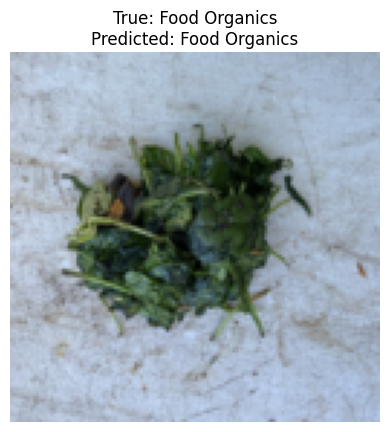

In [ ]:
# Pick a random image from test dataset
random_idx = random.randint(0, len(test_dataset)-1)
img, true_label = test_dataset[random_idx]

# Prepare image for model
img_tensor = img.unsqueeze(0).to(device)  # add batch dimension
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred_label = torch.argmax(output, dim=1).item()

# Display
img_display = img.permute(1,2,0).numpy()
img_display = img_display * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
img_display = np.clip(img_display, 0, 1)

plt.imshow(img_display)
plt.title(f"True: {classes[true_label]}\nPredicted: {classes[pred_label]}")
plt.axis('off')
plt.show()


Grid Visualization of Test Predictions

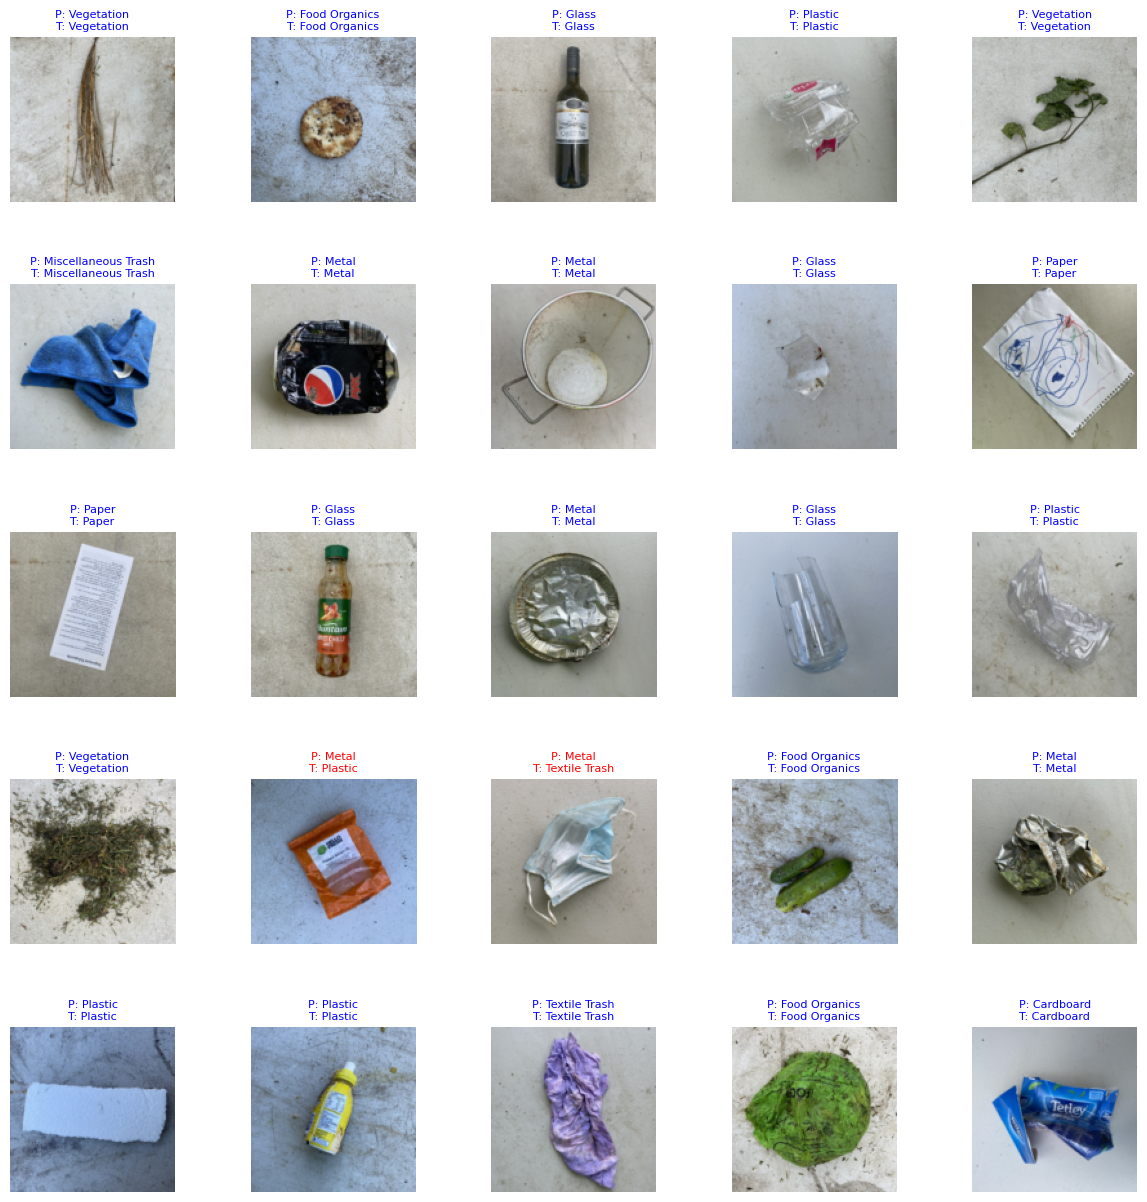

In [ ]:
W_grid, L_grid = 5,5
fig, axes = plt.subplots(L_grid, W_grid, figsize=(15,15))
axes = axes.ravel()

for i in range(W_grid*L_grid):
    idx = random.randint(0, len(test_dataset)-1)
    img, true_label = test_dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    img_display = img.permute(1,2,0).numpy()
    img_display = img_display * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img_display = np.clip(img_display, 0, 1)

    axes[i].imshow(img_display)
    color = 'blue' if pred_label == true_label else 'red'
    axes[i].set_title(f"P: {classes[pred_label]}\nT: {classes[true_label]}", fontsize=8, color=color)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()


### Model Evaluation

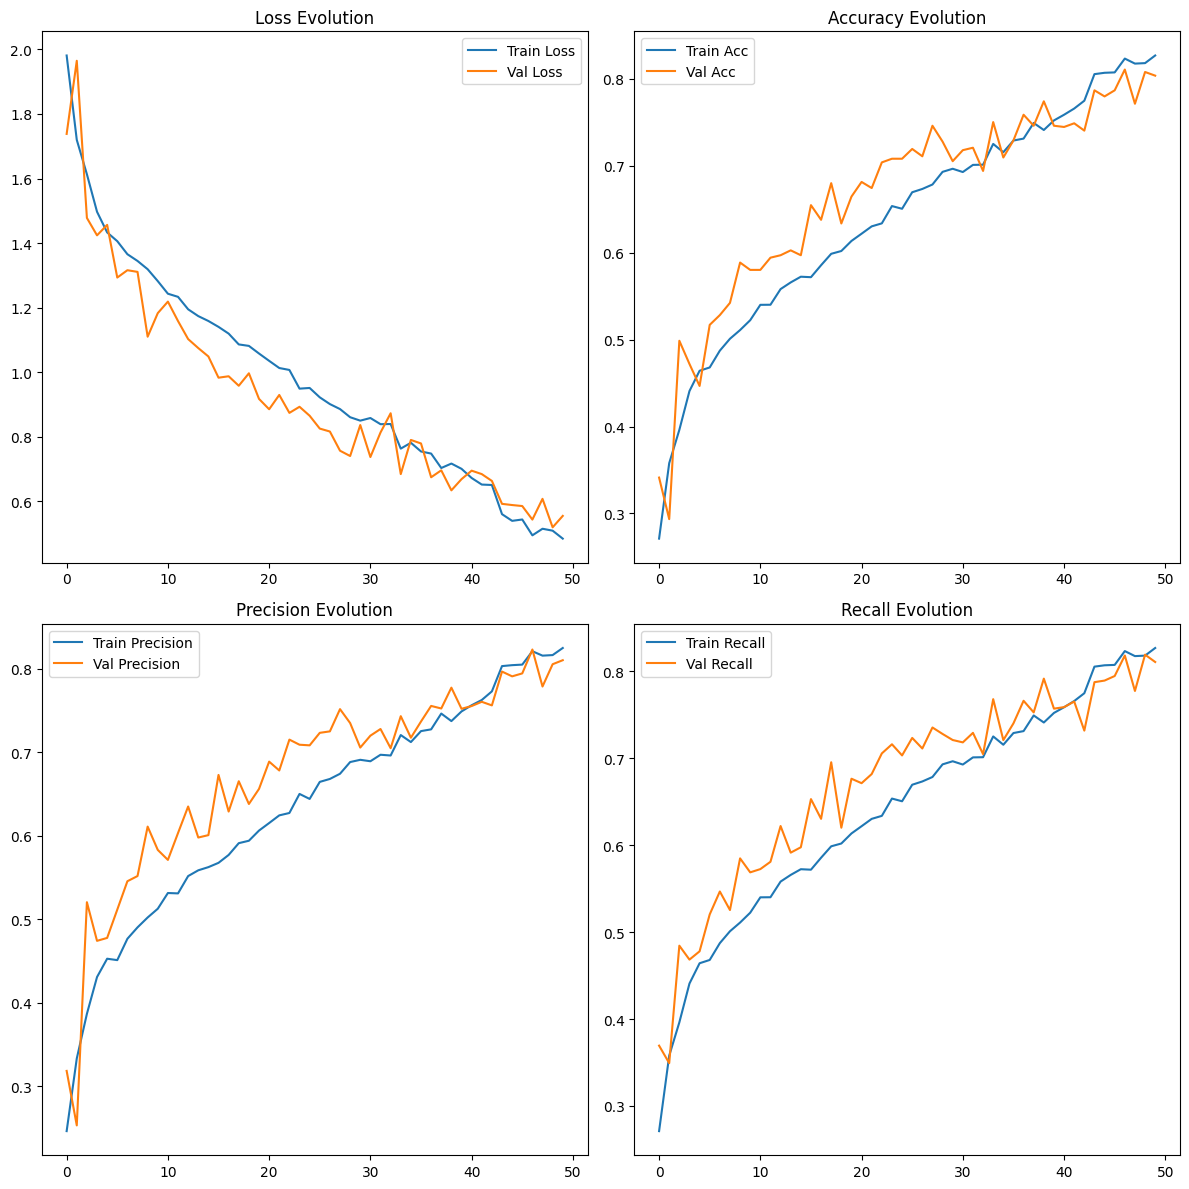

In [ ]:
# load history from file
history = load_history(history_path)

# ---- Plot training history ----
plt.figure(figsize=(12, 12))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Evolution')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(history['train_prec'], label='Train Precision')
plt.plot(history['val_prec'], label='Val Precision')
plt.title('Precision Evolution')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history['train_rec'], label='Train Recall')
plt.plot(history['val_rec'], label='Val Recall')
plt.title('Recall Evolution')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Load the model from the best checkpoint before evaluation
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        model.load_state_dict(ckpt['model_state_dict'])
        print("Loaded best model from checkpoint for evaluation.")
    else:
        model.load_state_dict(ckpt)
        print("Loaded model.state_dict() from checkpoint for evaluation.")


# ---- Evaluate model on test data ----
model.eval()
test_loss = 0.0
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute metrics
test_loss /= len(test_loader.dataset)
test_acc = sum(np.array(y_pred) == np.array(y_true)) / len(y_true)
test_prec = precision_score(y_true, y_pred, average='macro')
test_rec = recall_score(y_true, y_pred, average='macro')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Precision: {test_prec * 100:.2f}%")
print(f"Test Recall: {test_rec * 100:.2f}%")

Loaded best model from checkpoint for evaluation.
Test Loss: 0.5782
Test Accuracy: 80.47%
Test Precision: 80.12%
Test Recall: 81.47%


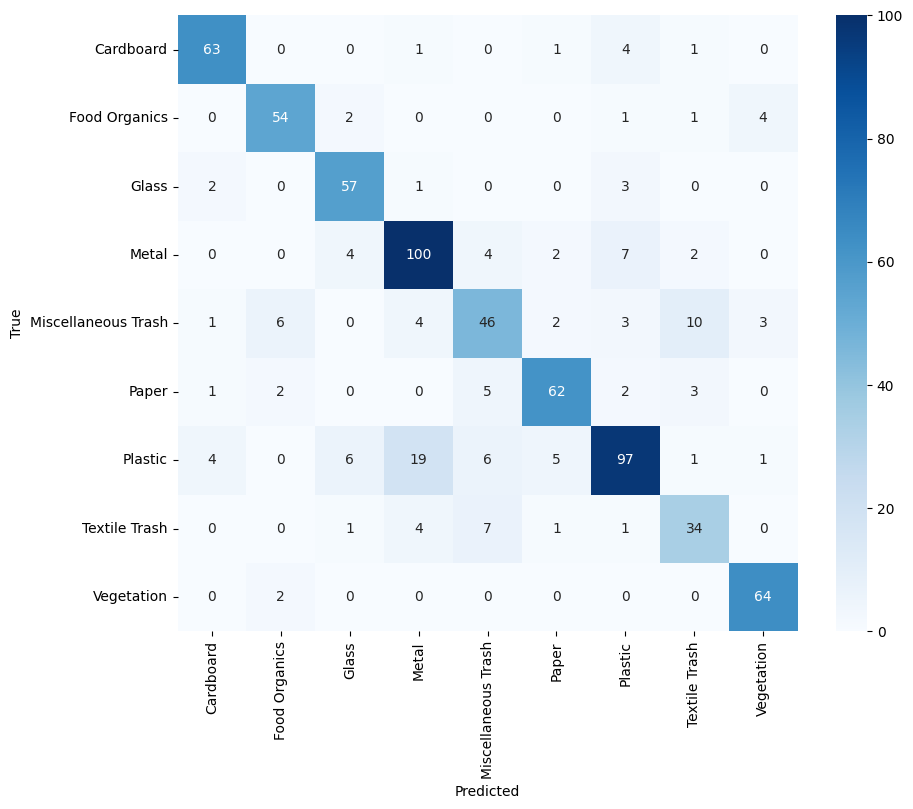

In [ ]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

                     precision    recall  f1-score   support

          Cardboard       0.89      0.90      0.89        70
      Food Organics       0.84      0.87      0.86        62
              Glass       0.81      0.90      0.86        63
              Metal       0.78      0.84      0.81       119
Miscellaneous Trash       0.68      0.61      0.64        75
              Paper       0.85      0.83      0.84        75
            Plastic       0.82      0.70      0.75       139
      Textile Trash       0.65      0.71      0.68        48
         Vegetation       0.89      0.97      0.93        66

           accuracy                           0.80       717
          macro avg       0.80      0.81      0.81       717
       weighted avg       0.80      0.80      0.80       717



## 2. Comparison the network with state-of-the-art networks


I chose ResNet18 and DenseNet121

### Helper functions

In [ ]:
# --- 2_model_factory ---
# returns a pretrained model with final classifier replaced for num_classes.
def get_pretrained_model(name, num_classes, feature_extract=False):
    """
    name: 'resnet18' or 'densenet121'
    feature_extract: if True, freeze backbone and only train final classifier
    """
    name = name.lower()
    # load model with pretrained weights (compatibility try-except for torchvision versions)
    if name == 'resnet18':
        try:
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        except Exception:
            model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        classifier_params = model.fc.parameters()
    elif name == 'densenet121':
        try:
            model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        except Exception:
            model = models.densenet121(pretrained=True)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
        classifier_params = model.classifier.parameters()
    else:
        raise ValueError("Unsupported model name")

    if feature_extract:
        # freeze all params except final classifier
        for param in model.parameters():
            param.requires_grad = False
        for p in classifier_params:
            p.requires_grad = True

    return model.to(device)



In [ ]:
# --- 3_training_helpers ---
# generic train/validate functions. records history dict with losses & accuracies per epoch.
from sklearn.metrics import precision_score, recall_score

def train_one_epoch(model, loader, optimizer, criterion, scaler=None, accum_steps=1):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels) / accum_steps
        if torch.cuda.is_available():
            scaler.scale(loss).backward()
        else:
            loss.backward()
        if (i + 1) % accum_steps == 0:
            if torch.cuda.is_available():
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        running_loss += float(loss.item()) * images.size(0) * accum_steps  # rescale back
        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())
    train_loss = running_loss / len(targets)
    train_acc = np.mean(np.array(preds) == np.array(targets))
    train_prec = precision_score(targets, preds, average='macro', zero_division=0)
    train_rec = recall_score(targets, preds, average='macro', zero_division=0)
    return train_loss, train_acc, train_prec, train_rec

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)
        running_loss += float(loss.item()) * images.size(0)
        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())
    val_loss = running_loss / len(targets)
    val_acc = np.mean(np.array(preds) == np.array(targets))
    val_prec = precision_score(targets, preds, average='macro', zero_division=0)
    val_rec = recall_score(targets, preds, average='macro', zero_division=0)
    return val_loss, val_acc, val_prec, val_rec

def evaluate_on_test(model, loader):
    model.eval()
    preds, targets = [], []
    device_type = device.type
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
                outputs = model(images)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # defensive: ensure lists not empty
    if len(targets) == 0:
        return "No test samples.", None

    # explicitly provide labels to avoid mismatch when some classes are missing
    label_list = list(range(num_classes))
    report = classification_report(targets, preds, labels=label_list, target_names=classes, zero_division=0)
    cm = confusion_matrix(targets, preds, labels=label_list)
    return report, cm

In [ ]:
# --- 4_train_finetune_function ---
# This function trains (fine-tunes) a given model name and returns the history & best model.
def run_finetune(name, feature_extract=False, epochs=12, batch_size_local=None, accum_steps=1, checkpoint_prefix='model'):
    """
    name: 'resnet18' or 'densenet121'
    feature_extract: if True freeze backbone (train only classifier)
    epochs: total epochs
    accum_steps: gradient accumulation steps to emulate larger batch
    """
    print(f"\n=== Training {name}  | feature_extract={feature_extract}  | epochs={epochs} ===")
    model = get_pretrained_model(name, num_classes=num_classes, feature_extract=feature_extract)

    # re-create optimizer for params that require grad
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
    # OneCycleLR: total_steps = epochs * steps_per_epoch
    steps_per_epoch = max(1, len(train_loader))
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=epochs * steps_per_epoch)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    device_type = device.type  # e.g. 'cuda' or 'cpu'
    scaler = torch.amp.GradScaler(device_type=device_type, enabled=(device_type == 'cuda'))


    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[],
               'train_prec':[], 'val_prec':[], 'train_rec':[], 'val_rec':[]}

    for epoch in range(epochs):
        t0 = time.time()
        # train (using accum steps)
        train_loss, train_acc, train_prec, train_rec = train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler, accum_steps=accum_steps)

        try:
            scheduler.step()
        except Exception:
            pass

        val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, criterion)

        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
        history['train_prec'].append(train_prec); history['val_prec'].append(val_prec)
        history['train_rec'].append(train_rec); history['val_rec'].append(val_rec)

        epoch_time = time.time() - t0
        print(f"Epoch {epoch+1}/{epochs}  time={epoch_time:.1f}s  train_loss={train_loss:.4f} train_acc={train_acc:.4f}  val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
        # checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': epoch, 'best_val_loss': best_val_loss}, f"{checkpoint_prefix}_{name}.pth")
            print("  saved best checkpoint")
    # load best weights
    model.load_state_dict(best_model_wts)
    return model, history


### ResNet18

In [ ]:
# --- ResNet: 1_train_resnet18 ---

# Config — change these if you want a different mode
model_name = 'resnet18'
feature_extract = False   # True => freeze backbone and train only final layer (fast); False => fine-tune whole network
epochs = 12
checkpoint_path = f'best_{model_name}_{"feat" if feature_extract else "ft"}.pth'
history_path = f'history_{model_name}_{"feat" if feature_extract else "ft"}.json'

print("Device:", device)
# Build model (uses get_pretrained_model from earlier cell)
model = get_pretrained_model(model_name, num_classes=num_classes, feature_extract=feature_extract)
print("Model created:", model_name, "feature_extract=", feature_extract)

# optimizer & scheduler
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
# basic LR scheduler, optional: change to OneCycleLR if you stepped per-batch
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

criterion = nn.CrossEntropyLoss()
device_type = device.type  # e.g. 'cuda' or 'cpu'
scaler = torch.amp.GradScaler(enabled=(device_type == 'cuda'))

best_val_loss = float('inf')
best_wts = copy.deepcopy(model.state_dict())
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(epochs):
    t0 = time.time()
    train_loss, train_acc, train_prec, train_rec = train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler, accum_steps=1)
    val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, criterion)
    scheduler.step(val_loss)  # reduce on plateau

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)

    print(f"[ResNet] Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}  time={time.time()-t0:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': epoch, 'best_val_loss': best_val_loss}, checkpoint_path)
        print("  Saved improved checkpoint:", checkpoint_path)

# load best weights at end
model.load_state_dict(best_wts)
torch.save(model.state_dict(), checkpoint_path.replace('.pth', '_final_state.pth'))
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print("Finished training ResNet. Best val loss:", best_val_loss, "History saved to", history_path)


Device: cuda
Model created: resnet18 feature_extract= False
[ResNet] Epoch 1/12  train_loss=1.0508 train_acc=0.6379 | val_loss=2.8574 val_acc=0.3750  time=49.5s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 2/12  train_loss=0.6941 train_acc=0.7604 | val_loss=1.6518 val_acc=0.5000  time=53.5s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 3/12  train_loss=0.5256 train_acc=0.8171 | val_loss=0.8065 val_acc=0.7500  time=50.3s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 4/12  train_loss=0.4090 train_acc=0.8616 | val_loss=0.3956 val_acc=0.7500  time=53.3s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 5/12  train_loss=0.3193 train_acc=0.8860 | val_loss=0.2980 val_acc=0.8750  time=54.0s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 6/12  train_loss=0.2794 train_acc=0.9038 | val_loss=0.1404 val_acc=0.8750  time=54.1s
  Saved improved checkpoint: best_resnet18_ft.pth
[ResNet] Epoch 7/12  train_loss=0.

Running validation on VAL set for ResNet...
VAL loss: 0.0315, VAL acc: 1.0000, VAL prec: 1.0000, VAL rec: 1.0000
Classification report (VAL):
                     precision    recall  f1-score   support

          Cardboard       0.86      0.72      0.79        69
      Food Organics       0.95      0.85      0.90        62
              Glass       0.85      0.71      0.78        63
              Metal       0.62      0.93      0.75       118
Miscellaneous Trash       0.78      0.61      0.68        74
              Paper       0.71      0.93      0.81        75
            Plastic       0.89      0.60      0.72       138
      Textile Trash       0.88      0.75      0.81        48
         Vegetation       0.81      0.98      0.89        65

           accuracy                           0.78       712
          macro avg       0.82      0.79      0.79       712
       weighted avg       0.81      0.78      0.78       712



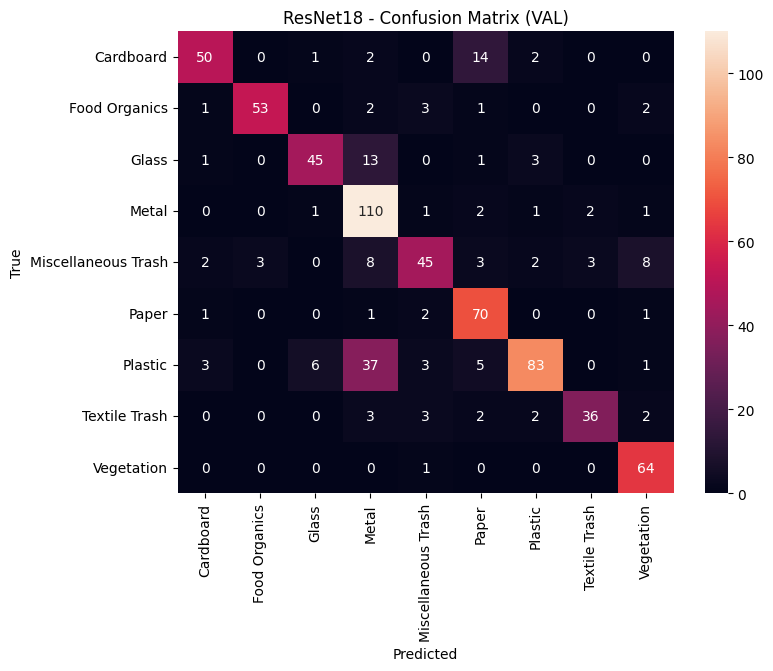

In [ ]:
# --- ResNet: 2_validate_resnet18_on_val ---

# Load best checkpoint if you want to evaluate the saved best model (optional)
ckpt = torch.load(f'best_resnet18_{"feat" if False else "ft"}.pth', map_location=device)  # adjust filename if feature_extract True
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)

print("Running validation on VAL set for ResNet...")
val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, nn.CrossEntropyLoss())
print(f"VAL loss: {val_loss:.4f}, VAL acc: {val_acc:.4f}, VAL prec: {val_prec:.4f}, VAL rec: {val_rec:.4f}")

# Detailed per-class report & confusion matrix using evaluate_on_test-like function on val_loader
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("Classification report (VAL):")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("ResNet18 - Confusion Matrix (VAL)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


Evaluating ResNet on TEST set...
Classification report (TEST):
                      precision    recall  f1-score   support

          Cardboard       0.78      0.60      0.68        70
      Food Organics       0.94      0.77      0.85        62
              Glass       0.87      0.76      0.81        63
              Metal       0.64      0.92      0.75       119
Miscellaneous Trash       0.71      0.73      0.72        75
              Paper       0.63      0.87      0.73        75
            Plastic       0.90      0.55      0.68       139
      Textile Trash       0.83      0.71      0.76        48
         Vegetation       0.81      0.97      0.88        66

           accuracy                           0.76       717
          macro avg       0.79      0.76      0.76       717
       weighted avg       0.78      0.76      0.75       717



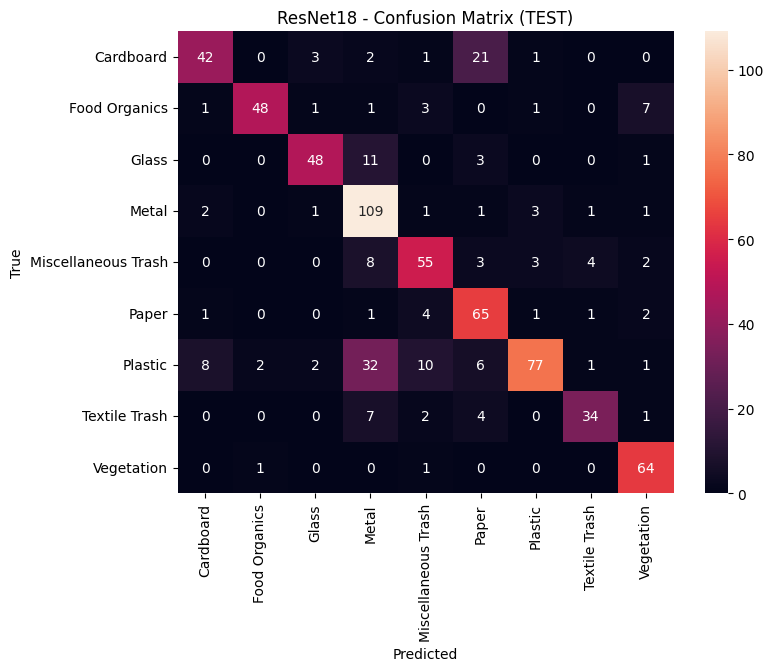

In [ ]:
# --- ResNet: 3_evaluate_resnet18_on_test ---

# Final evaluation on the TEST set for ResNet (classification report + confusion matrix)
print("Evaluating ResNet on TEST set...")
report, cm = evaluate_on_test(model, test_loader)   # uses helper evaluate_on_test defined earlier
print("Classification report (TEST):\n", report)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("ResNet18 - Confusion Matrix (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


### DenseNet121

In [ ]:
# --- DenseNet: 4_train_densenet121 ---

model_name = 'densenet121'
feature_extract = False   # set True for just training classifier head (faster)
epochs = 12
checkpoint_path = f'best_{model_name}_{"feat" if feature_extract else "ft"}.pth'
history_path = f'history_{model_name}_{"feat" if feature_extract else "ft"}.json'

print("Device:", device)
model = get_pretrained_model(model_name, num_classes=num_classes, feature_extract=feature_extract)
print("Model created:", model_name, "feature_extract=", feature_extract)

params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

criterion = nn.CrossEntropyLoss()
device_type = device.type  # e.g. 'cuda' or 'cpu'
scaler = torch.amp.GradScaler(enabled=(device_type == 'cuda'))


best_val_loss = float('inf')
best_wts = copy.deepcopy(model.state_dict())
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(epochs):
    t0 = time.time()
    train_loss, train_acc, train_prec, train_rec = train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler, accum_steps=1)
    val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)

    print(f"[DenseNet] Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}  time={time.time()-t0:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': epoch, 'best_val_loss': best_val_loss}, checkpoint_path)
        print("  Saved improved checkpoint:", checkpoint_path)

# load best weights and save history
model.load_state_dict(best_wts)
torch.save(model.state_dict(), checkpoint_path.replace('.pth', '_final_state.pth'))
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print("Finished training DenseNet. Best val loss:", best_val_loss, "History saved to", history_path)


Device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Induwara/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [02:16<00:00, 237kB/s] 


Model created: densenet121 feature_extract= False
[DenseNet] Epoch 1/12  train_loss=0.9105 train_acc=0.6812 | val_loss=0.9322 val_acc=0.6250  time=219.9s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 2/12  train_loss=0.5472 train_acc=0.8093 | val_loss=0.6464 val_acc=0.8750  time=132.7s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 3/12  train_loss=0.4034 train_acc=0.8591 | val_loss=1.4002 val_acc=0.5000  time=146.1s
[DenseNet] Epoch 4/12  train_loss=0.3287 train_acc=0.8882 | val_loss=0.3298 val_acc=0.8750  time=150.3s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 5/12  train_loss=0.2470 train_acc=0.9132 | val_loss=0.4315 val_acc=0.8750  time=151.9s
[DenseNet] Epoch 6/12  train_loss=0.2238 train_acc=0.9227 | val_loss=0.1510 val_acc=0.8750  time=140.9s
  Saved improved checkpoint: best_densenet121_ft.pth
[DenseNet] Epoch 7/12  train_loss=0.1992 train_acc=0.9320 | val_loss=0.8526 val_acc=0.8750  time=132.0s
[DenseNet]

Running validation on VAL set for DenseNet...
VAL loss: 0.0275, VAL acc: 1.0000, VAL prec: 1.0000, VAL rec: 1.0000
Classification report (VAL):
                     precision    recall  f1-score   support

          Cardboard       0.93      0.90      0.91        69
      Food Organics       0.87      0.97      0.92        62
              Glass       0.95      0.90      0.93        63
              Metal       0.87      0.86      0.87       118
Miscellaneous Trash       0.74      0.69      0.71        74
              Paper       0.94      0.89      0.92        75
            Plastic       0.83      0.88      0.86       138
      Textile Trash       0.89      0.88      0.88        48
         Vegetation       0.97      0.97      0.97        65

           accuracy                           0.88       712
          macro avg       0.89      0.88      0.88       712
       weighted avg       0.88      0.88      0.88       712



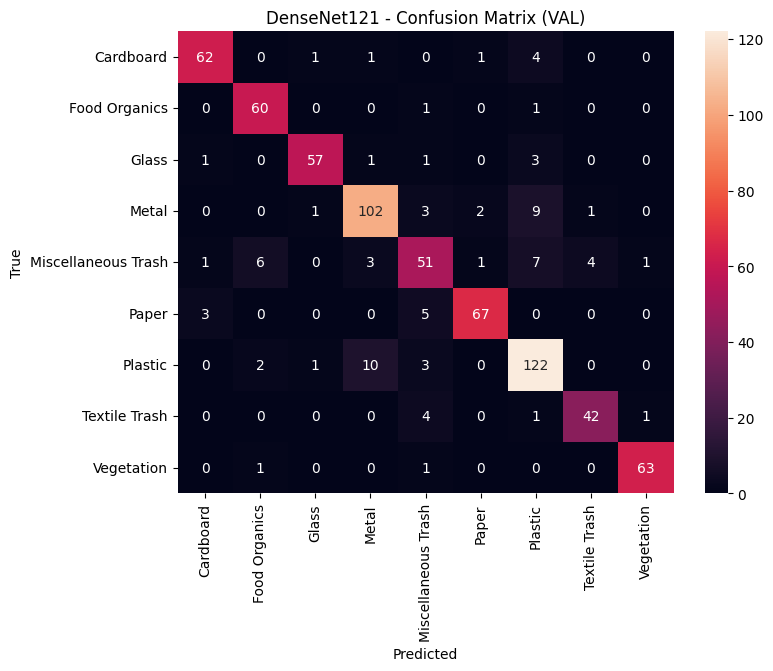

In [ ]:
# --- DenseNet: 5_validate_densenet121_on_val ---

# Load best checkpoint if desired
ckpt = torch.load(f'best_densenet121_{"feat" if False else "ft"}.pth', map_location=device)  # adjust if you trained feature_extract True
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)

print("Running validation on VAL set for DenseNet...")
val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, nn.CrossEntropyLoss())
print(f"VAL loss: {val_loss:.4f}, VAL acc: {val_acc:.4f}, VAL prec: {val_prec:.4f}, VAL rec: {val_rec:.4f}")

y_true = []; y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        device_type = device.type  # e.g. 'cuda' or 'cpu'
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == 'cuda')):
            outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds); y_true.extend(labels.cpu().numpy())

print("Classification report (VAL):")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("DenseNet121 - Confusion Matrix (VAL)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


Evaluating DenseNet on TEST set...
Classification report (TEST):
                      precision    recall  f1-score   support

          Cardboard       0.94      0.97      0.96        70
      Food Organics       0.89      0.92      0.90        62
              Glass       0.91      0.97      0.94        63
              Metal       0.91      0.82      0.86       119
Miscellaneous Trash       0.87      0.79      0.83        75
              Paper       0.92      0.89      0.91        75
            Plastic       0.86      0.92      0.89       139
      Textile Trash       0.78      0.83      0.81        48
         Vegetation       0.94      0.95      0.95        66

           accuracy                           0.89       717
          macro avg       0.89      0.90      0.89       717
       weighted avg       0.89      0.89      0.89       717



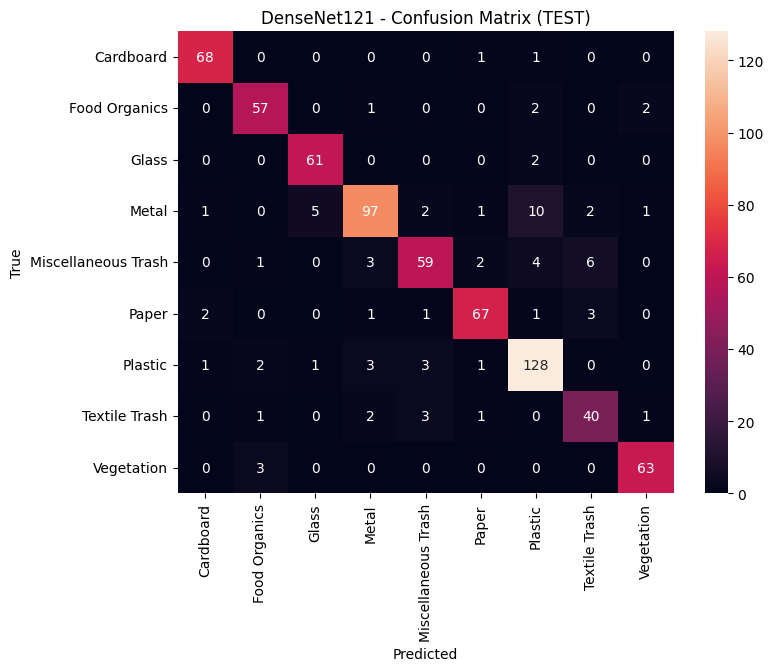

In [ ]:
# --- DenseNet: 6_evaluate_densenet121_on_test ---
print("Evaluating DenseNet on TEST set...")
report, cm = evaluate_on_test(model, test_loader)
print("Classification report (TEST):\n", report)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("DenseNet121 - Confusion Matrix (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


### Final Evaluation and Comparison